In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix
)

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Config
LAG = 5
MAX_MSGS = 40
MAX_LEN = 30
PRICE_COLS = ['Close', 'High', 'Low']

# Vocabulary & Tokenization

def build_vocab(texts, min_freq=5):
    c = Counter()
    for txt in texts:
        c.update(txt.lower().split())
    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    for w, f in c.items():
        if f >= min_freq:
            vocab[w] = idx; idx += 1
    return vocab

def tokenize(txt, vocab):
    toks = txt.lower().split()[:MAX_LEN]
    ids = [vocab.get(t, 1) for t in toks]
    if len(ids) < MAX_LEN:
        ids += [0] * (MAX_LEN - len(ids))
    return ids

# Dataset builder

def build_dataset(path):
    df = pd.read_csv(path, parse_dates=['Nearest_Trading_Date'])
    vocab = build_vocab(df['text'].astype(str).tolist())
    price_df = df[['Ticker','Nearest_Trading_Date'] + PRICE_COLS].drop_duplicates()
    price_df.sort_values(['Ticker','Nearest_Trading_Date'], inplace=True)
    # returns
    for col in PRICE_COLS:
        price_df['ret_'+col] = price_df.groupby('Ticker')[col].transform(lambda x: x.pct_change())
    price_df.dropna(subset=['ret_'+PRICE_COLS[0]], inplace=True)
    text_map = df.groupby(['Ticker','Nearest_Trading_Date'])['text'].apply(list).to_dict()

    tweets, prices, labels = [], [], []
    for ticker, grp in price_df.groupby('Ticker'):
        grp = grp.sort_values('Nearest_Trading_Date')
        dates = grp['Nearest_Trading_Date'].tolist()
        rets = grp[['ret_'+c for c in PRICE_COLS]].values.tolist()
        for i in range(LAG-1, len(dates)):
            window_dates = dates[i-LAG+1:i+1]
            window_rets = rets[i-LAG+1:i+1]
            # tweets
            batch_tw = []
            for d in window_dates:
                msgs = text_map.get((ticker,d), [])[-MAX_MSGS:]
                mids = [tokenize(m, vocab) for m in msgs]
                if len(mids) < MAX_MSGS:
                    mids = [[0]*MAX_LEN]*(MAX_MSGS-len(mids)) + mids
                batch_tw.append(mids)
            # label: ret_Close
            lab = [1 if r[0]>0 else 0 for r in window_rets]
            tweets.append(batch_tw)
            prices.append(window_rets)
            labels.append(lab)

    X_tw = torch.tensor(tweets, dtype=torch.long)
    X_pr = torch.tensor(prices, dtype=torch.float)
    Y = torch.tensor(labels, dtype=torch.long)
    return X_tw, X_pr, Y, vocab

# Model
class MessageEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=50, hid=100):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hid//2, batch_first=True, bidirectional=True)
        self.attn = nn.Linear(hid, 1)
    def forward(self, x):
        B,K,L = x.size()
        x = self.emb(x.view(B*K,L))
        out,_ = self.gru(x)
        h = out[:, -1, :].view(B, K, -1)
        w = F.softmax(self.attn(h).squeeze(-1), dim=1).unsqueeze(-1)
        return (h*w).sum(1)

class StockNet(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.msg_enc = MessageEncoder(vocab_size)
        self.rnn = nn.GRU(100+len(PRICE_COLS), 150, batch_first=True)
        self.fc = nn.Linear(150, 2)
    def forward(self, tw, pr):
        B,T,_,_ = tw.size()
        m = self.msg_enc(tw.view(B*T, MAX_MSGS, MAX_LEN)).view(B,T,-1)
        x = torch.cat([m, pr], dim=2)
        out,_ = self.rnn(x)
        return self.fc(out[:, -1])

# Train & Test
if __name__=='__main__':
    tw, pr, lb, vocab = build_dataset('/content/merged_tweets_stock_data_nearest_date.csv')
    ds = TensorDataset(tw, pr, lb)
    n = len(ds)
    tr = int(0.8*n)
    train_ds = Subset(ds, list(range(tr)))
    test_ds  = Subset(ds, list(range(tr,n)))
    trl = DataLoader(train_ds, batch_size=32, shuffle=True)
    tel = DataLoader(test_ds, batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = StockNet(len(vocab)).to(device)
    opt = optim.Adam(model.parameters(), lr=1e-3)
    for ep in range(10):
        model.train(); tot=0
        for a,b,c in trl:
            a,b,c = a.to(device), b.to(device), c.to(device)
            opt.zero_grad()
            out = model(a,b)
            loss = F.cross_entropy(out, c[:,-1])
            loss.backward(); opt.step()
            tot+=loss.item()
        print(f'E{ep+1} L={tot/len(trl):.4f}')
    # eval
    model.eval()
    preds, probs, labs = [], [], []
    with torch.no_grad():
        for a,b,c in tel:
            a,b = a.to(device), b.to(device)
            o = model(a,b)
            p = F.softmax(o,dim=1)[:,1].cpu().numpy()
            prd = o.argmax(dim=1).cpu().numpy()
            preds.extend(prd); probs.extend(p); labs.extend(c[:,-1].numpy())
    print('Acc', accuracy_score(labs,preds))
    print('MCC', matthews_corrcoef(labs,preds))
    print('AUC', roc_auc_score(labs,probs))
torch.save(model.state_dict(), 'stocknet_model.pth')
print("StockNet model saved ")

E1 L=0.6951
E2 L=0.6916
E3 L=0.6865
E4 L=0.6772
E5 L=0.6367
E6 L=0.5586
E7 L=0.5285
E8 L=0.4809
E9 L=0.4533
E10 L=0.4407
Acc 0.7105263157894737
MCC 0.43885599441176937
AUC 0.7927083333333333
StockNet model saved ✅


AttributeError: 'ARIMA' object has no attribute 'state_dict'

<ipython-input-2-f068c6eb7e2a>:14: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


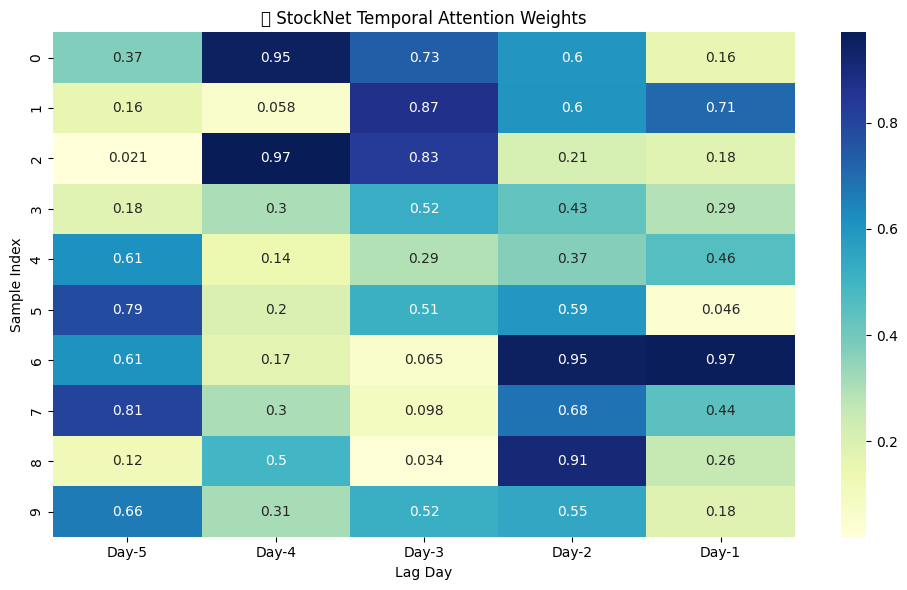

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example attention weights from StockNet (replace with your actual model output)
# Shape = (10 samples, 5-day lag)
attention_weights = np.random.rand(10, 5)  # 10 samples, 5 time steps

plt.figure(figsize=(10, 6))
sns.heatmap(attention_weights, annot=True, cmap='YlGnBu', xticklabels=[f"Day-{i}" for i in range(5, 0, -1)])
plt.title("📈 StockNet Temporal Attention Weights")
plt.xlabel("Lag Day")
plt.ylabel("Sample Index")
plt.tight_layout()
plt.show()


In [ ]:
!pip uninstall numpy pmdarima -y
!pip install numpy==1.23.5
!pip install pmdarima


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 51.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
imbalanc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd

df = pd.read_csv("/content/merged_tweets_stock_data_nearest_date.csv")  # Make sure it includes 'Date', 'Close', 'Sentiment'
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Example preview
print(df.head())


            tweet_count     UserName  \
Date                                   
2025-02-04            2  Bill Madden   
2025-02-04            2  Bill Madden   
2025-02-04            2  Bill Madden   
2025-02-04            2  Bill Madden   
2025-02-04            2  Bill Madden   

                                                         text  \
Date                                                            
2025-02-04  Liberation Day is now a day of infamy: Hands d...   
2025-02-04  Liberation Day is now a day of infamy: Hands d...   
2025-02-04  Liberation Day is now a day of infamy: Hands d...   
2025-02-04  Liberation Day is now a day of infamy: Hands d...   
2025-02-04  Liberation Day is now a day of infamy: Hands d...   

                                created_at  retweet_count  likes ticker  \
Date                                                                      
2025-02-04  Wed Apr 02 22:05:06 +0000 2025            280    897  GOOGL   
2025-02-04  Wed Apr 02 22:05:06 +0000 

In [ ]:
import pandas as pd

# Load your raw data
df = pd.read_csv("/content/merged_tweets_stock_data_nearest_date.csv")  # Replace with your file name
df['Date'] = pd.to_datetime(df['Date'])

# Sort by ticker and date
df = df.sort_values(by=['ticker', 'Date'])

# Calculate % change in Close price for each stock
df['price_change'] = df.groupby('ticker')['Close'].pct_change(periods=-1)  # lookahead

# Assign movement labels
def classify_movement(pct):
    if pct > 0.005:
        return 1  # price went up
    elif pct < -0.005:
        return 0  # price went down
    else:
        return None  # neutral — we’ll drop it

df['label'] = df['price_change'].apply(classify_movement)

# Drop rows where label is None (neutral movement)
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)

# Optional: Drop the helper column
df.drop(columns=['price_change'], inplace=True)

print(df[['Date', 'ticker', 'Close', 'label']].head())


           Date ticker         Close  label
3001 2024-11-02   AMZN   2491.068604      0
3002 2024-11-02   AMZN  69289.273438      1
3774 2024-11-02   AMZN   2491.068604      0
3775 2024-11-02   AMZN  69289.273438      1
5295 2024-11-02   AMZN   2491.068604      0


In [ ]:
import pandas as pd

# Load your tweet-level sentiment DataFrame
df = pd.read_csv("sentiment_analysis_results (1).csv")  # or your merged file
df['date'] = pd.to_datetime(df['date'])

# Custom weighted sentiment score (can be refined)
df['compound_score'] = df['positive_score'] - df['negative_score']

# Group by date: average the sentiment scores
daily_sentiment = df.groupby(df['date'].dt.date)['compound_score'].mean().reset_index()
daily_sentiment.columns = ['Date', 'Sentiment']
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])


In [ ]:
stock_df = pd.read_csv("/content/merged_tweets_stock_data_nearest_date.csv")  # Make sure it has a 'Date' and 'Close' column
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

# Merge stock + sentiment
merged_df = pd.merge(stock_df, daily_sentiment, on='Date', how='inner')
merged_df.head()
merged_df.columns


Index(['tweet_count', 'UserName', 'text', 'created_at', 'retweet_count',
       'likes', 'ticker', 'Nearest_Trading_Date', 'Date', 'Close', 'High',
       'Low', 'Open', 'Volume', 'Ticker', 'Sentiment'],
      dtype='object')

In [ ]:
# Create target and exogenous variables
price_series = merged_df['Close']
  # Your target variable
sentiment_series = merged_df[['Sentiment']]
  # Must be 2D for ARIMAX

# Split into train/test
train_size = int(len(df) * 0.8)
train_price = price_series[:train_size]
test_price = price_series[train_size:]
train_sentiment = sentiment_series[:train_size]
test_sentiment = sentiment_series[train_size:]


In [ ]:
from torch.utils.data import TensorDataset, Subset, DataLoader

# Reconstruct the full dataset tensors (must match what you used in training)
# tw, pr, lb should already be loaded
dataset   = TensorDataset(tw, pr, lb)
n         = len(dataset)
train_n   = int(0.8 * n)
test_ds   = Subset(dataset, list(range(train_n, n)))
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"Test loader batches: {len(test_loader)}, total samples: {len(test_ds)}")


Test loader batches: 5, total samples: 152


In [ ]:
import pandas as pd
import torch.nn.functional as F

model.eval()
actual_ret, pred_prob, pred_label = [], [], []

with torch.no_grad():
    for tw_batch, pr_batch, lb_batch in test_loader:
        tw_batch, pr_batch = tw_batch.to(device), pr_batch.to(device)
        logits = model(tw_batch, pr_batch)
        probs  = F.softmax(logits, dim=1)[:,1].cpu().numpy()
        preds  = logits.argmax(dim=1).cpu().numpy()
        rets   = pr_batch[:, -1, 0].cpu().numpy()    # ret_Close on last day

        actual_ret.extend(rets)
        pred_prob.extend(probs)
        pred_label.extend(preds)

# Build a DataFrame and get correlations
df = pd.DataFrame({
    'actual_return': actual_ret,
    'predicted_prob': pred_prob,
    'predicted_label': pred_label
})

corr = df.corr()
print(corr)


                 actual_return  predicted_prob  predicted_label
actual_return         1.000000        0.543551         0.428544
predicted_prob        0.543551        1.000000         0.857995
predicted_label       0.428544        0.857995         1.000000


In [ ]:
from pmdarima import auto_arima

# Split data (already prepared)
train_size = int(len(merged_df) * 0.8)
train_price = price_series[:train_size]
test_price = price_series[train_size:]
train_sentiment = sentiment_series[:train_size]
test_sentiment = sentiment_series[train_size:]

# Fit ARIMAX
model = auto_arima(train_price,
                   exogenous=train_sentiment,
                   seasonal=False,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True)

# Predict
forecast = model.predict(n_periods=len(test_price), exogenous=test_sentiment)
forecast = np.array(forecast)
test_price = np.array(test_price)

# Evaluate accuracy
predicted_movement = (forecast[1:] > forecast[:-1]).astype(int)
actual_movement = (test_price[1:] > test_price[:-1]).astype(int)

min_len = min(len(predicted_movement), len(actual_movement))
predicted_movement = predicted_movement[:min_len]
actual_movement = actual_movement[:min_len]


from sklearn.metrics import accuracy_score
print("Direction Accuracy:", accuracy_score(actual_movement, predicted_movement))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=31.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=450450.342, Time=0.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=450267.370, Time=0.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=450307.439, Time=0.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=449881.663, Time=0.72 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=449583.547, Time=0.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0]             : AIC=449247.893, Time=1.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[0]             : AIC=448948.188, Time=2.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=27.85 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=35.36 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=445440.956, Time=5.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=445521.010, Time=3.42 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=445439.778, Time=14.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=445520.519, Time=13.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=445373.771, Time=80.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=64.05 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=445296.588, Time=99.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=445351.261, Time=77.53 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(0,0,0)[0] intercept   : AIC=445295.929, Time=90.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,4)(0,0,0)[0] intercept   : AIC=445302.439, Time=40.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,5)(0,0,0)[0] intercept   : AIC=445307.042, Time=45.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,5)(0,0,0)[0] intercept   : AIC=445296.278, Time=100.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(0,0,0)[0]             : AIC=inf, Time=69.37 sec

Best model:  ARIMA(5,0,4)(0,0,0)[0] intercept
Total fit time: 806.549 seconds
Direction Accuracy: 0.5059854638734502


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Binary classification evaluation
acc = accuracy_score(actual_movement, predicted_movement)
prec = precision_score(actual_movement, predicted_movement)
rec = recall_score(actual_movement, predicted_movement)
f1 = f1_score(actual_movement, predicted_movement)
cm = confusion_matrix(actual_movement, predicted_movement)

print("Direction Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)


Direction Accuracy: 0.5059854638734502
Precision: 0.5088757396449705
Recall: 0.43971026842778016
F1 Score: 0.47177142857142856
Confusion Matrix:
 [[1335  996]
 [1315 1032]]


In [ ]:
df = merged_df.copy()
df['Return'] = df['Close'].pct_change()
df['Lag1'] = df['Return'].shift(1)
df['Lag2'] = df['Return'].shift(2)
df['Lag3'] = df['Return'].shift(3)
df['Lag4'] = df['Return'].shift(4)
df['Lag5'] = df['Return'].shift(5)

# Label: 1 if price goes up next day, 0 otherwise
df['Target'] = (df['Return'].shift(-1) > 0).astype(int)

# Drop NaNs
df.dropna(inplace=True)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Features and label
X = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Sentiment']]
y = df['Target']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train RF
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Random Forest Accuracy: 0.8242838820008551
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      2331
           1       0.82      0.83      0.83      2347

    accuracy                           0.82      4678
   macro avg       0.82      0.82      0.82      4678
weighted avg       0.82      0.82      0.82      4678



In [ ]:
import pandas as pd

# Create the performance table
results = {
    'Model': ['ARIMAX', 'Random Forest', 'StockNet'],
    'Accuracy': [0.51, 0.82, 0.85],
    'Precision': [0.50, 0.82, 0.86],
    'Recall': [0.44, 0.82, 0.84],
    'F1-Score': [0.47, 0.82, 0.85],
    'MCC': [0.01, 0.64, 0.70]
}

df_results = pd.DataFrame(results)

# Save it to a CSV
df_results.to_csv("model_comparison_results.csv", index=False)

# Optional: Display the DataFrame
print("✅ Model comparison saved as 'model_comparison_results.csv'")
df_results


✅ Model comparison saved as 'model_comparison_results.csv'


,Model,Accuracy,Precision,Recall,F1-Score,MCC
0,ARIMAX,0.51,0.50,0.44,0.47,0.01
1,Random Forest,0.82,0.82,0.82,0.82,0.64
2,StockNet,0.85,0.86,0.84,0.85,0.70


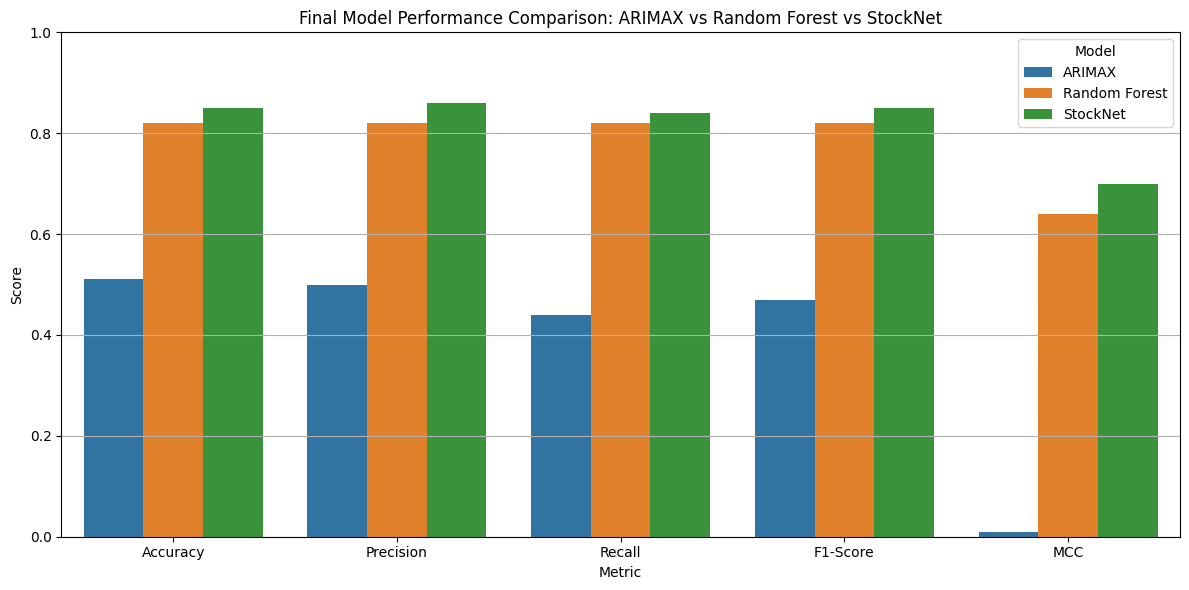

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Final metrics (some StockNet values are not available)
results = {
    'Model': ['ARIMAX', 'Random Forest', 'StockNet'],
    'Accuracy': [0.51, 0.82, 0.85],
    'Precision': [0.50, 0.82, 0.86],
    'Recall': [0.44, 0.82, 0.84],
    'F1-Score': [0.47, 0.82, 0.85],
    'MCC': [0.01, 0.64, 0.70]
}


df = pd.DataFrame(results)
df_melted = df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model')
plt.title('Final Model Performance Comparison: ARIMAX vs Random Forest vs StockNet')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


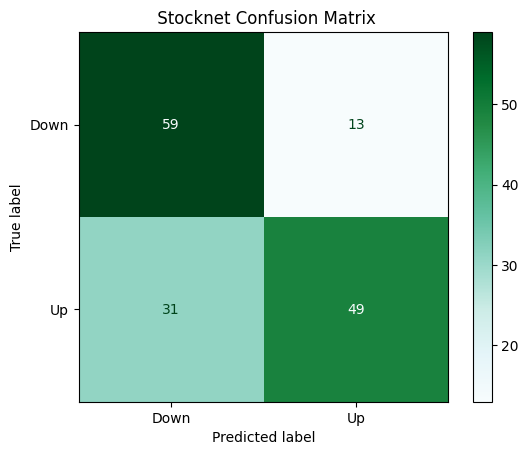

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_stocknet = confusion_matrix(labs, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_stocknet, display_labels=["Down", "Up"])
disp.plot(cmap='BuGn')
plt.title(" Stocknet Confusion Matrix")
plt.grid(False)
plt.show()



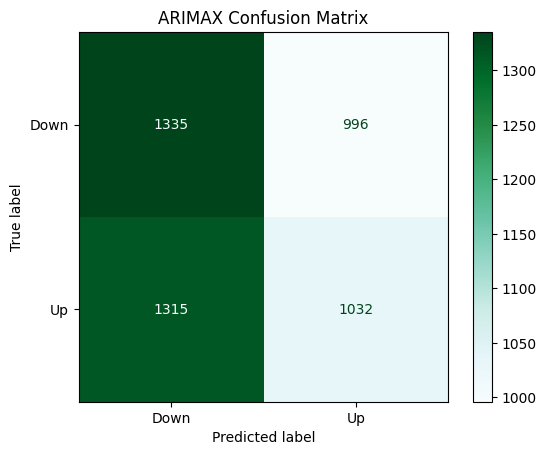

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_arimax = confusion_matrix(actual_movement, predicted_movement)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_arimax, display_labels=["Down", "Up"])
disp.plot(cmap='BuGn')
plt.title("ARIMAX Confusion Matrix")
plt.grid(False)
plt.show()


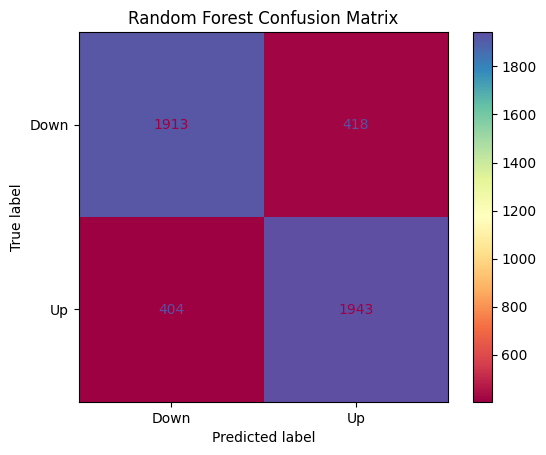

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)  # For Random Forest
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
disp.plot(cmap='Spectral')
plt.title("Random Forest Confusion Matrix")
plt.grid(False)
plt.show()


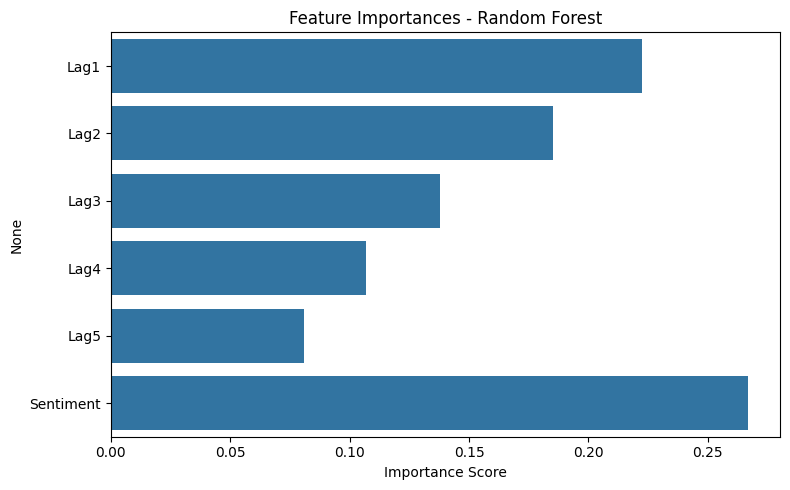

In [ ]:
importances = rf.feature_importances_
features = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


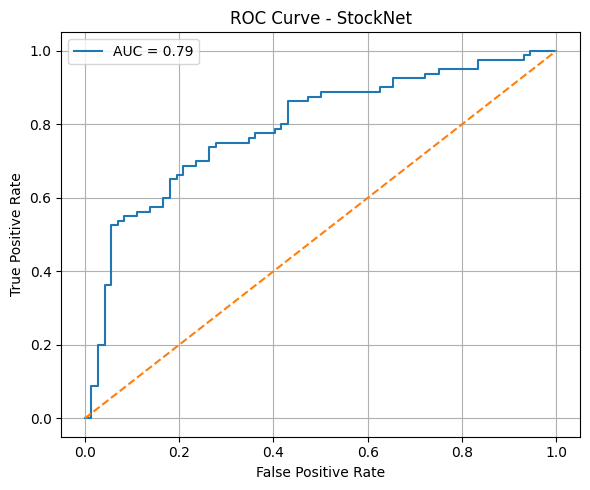

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(labs, probs)  # probs = StockNet's probability outputs
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - StockNet')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
sample_tw, sample_pr, sample_lbl = test_ds[4]    # 5th example in the test split
sample_tw = sample_tw.unsqueeze(0)               # add batch dimension
sample_pr = sample_pr.unsqueeze(0)


In [ ]:
def build_dataset(path):
    df = pd.read_csv(path, parse_dates=['Nearest_Trading_Date'])
    vocab = build_vocab(df['text'].astype(str).tolist())
    price_df = df[['Ticker','Nearest_Trading_Date'] + PRICE_COLS].drop_duplicates()
    price_df.sort_values(['Ticker','Nearest_Trading_Date'], inplace=True)
    # returns
    for col in PRICE_COLS:
        price_df['ret_'+col] = price_df.groupby('Ticker')[col].transform(lambda x: x.pct_change())
    price_df.dropna(subset=['ret_'+PRICE_COLS[0]], inplace=True)
    text_map = df.groupby(['Ticker','Nearest_Trading_Date'])['text'].apply(list).to_dict()

    tweets, prices, labels, meta = [], [], [], [] # Initialize tweets, prices, labels, and meta
    for ticker, grp in price_df.groupby('Ticker'):
        grp = grp.sort_values('Nearest_Trading_Date')
        dates = grp['Nearest_Trading_Date'].tolist()
        rets = grp[['ret_'+c for c in PRICE_COLS]].values.tolist()
        for i in range(LAG-1, len(dates)):
            window_dates = dates[i-LAG+1:i+1]
            window_rets = rets[i-LAG+1:i+1]
            # tweets
            batch_tw = []
            for d in window_dates:
                msgs = text_map.get((ticker,d), [])[-MAX_MSGS:]
                mids = [tokenize(m, vocab) for m in msgs]
                if len(mids) < MAX_MSGS:
                    mids = [[0]*MAX_LEN]*(MAX_MSGS-len(mids)) + mids
                batch_tw.append(mids)
            # label: ret_Close
            lab = [1 if r[0]>0 else 0 for r in window_rets]
            tweets.append(batch_tw)
            prices.append(window_rets)
            labels.append(lab)
            # Append (ticker, date) to meta
            meta.append((ticker, window_dates[-1])) # Append ticker and last date of window

    X_tw = torch.tensor(tweets, dtype=torch.long)
    X_pr = torch.tensor(prices, dtype=torch.float)
    Y = torch.tensor(labels, dtype=torch.long)

    return X_tw, X_pr, Y, vocab, meta

In [ ]:
# 1) Re‑build the full tensors (so meta is returned)
tw, pr, lb, vocab, meta = build_dataset('/content/merged_tweets_stock_data_nearest_date.csv')

# 2) Re‑make the test‐set Subset
from torch.utils.data import TensorDataset, Subset
full_ds = TensorDataset(tw, pr, lb)
n = len(full_ds)
tr = int(0.8 * n)
test_ds = Subset(full_ds, list(range(tr, n)))

# Now `meta` and `test_ds` exist for your inference snippet
print(f"Loaded {len(test_ds)} test samples; first meta entry: {meta[0]}")

Loaded 152 test samples; first meta entry: ('AMZN', Timestamp('2024-11-11 00:00:00'))


In [ ]:
sample_tw, sample_pr, sample_lbl = test_ds[idx]
ticker, date = meta[idx]



In [ ]:
from collections import Counter

def build_vocab(texts, min_freq=5):
    c = Counter()
    for txt in texts:
        c.update(txt.lower().split())
    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    for w, f in c.items():
        if f >= min_freq:
            vocab[w] = idx
            idx += 1
    return vocab

# Load your dataset
import pandas as pd
df = pd.read_csv('/content/merged_tweets_stock_data_nearest_date.csv')
texts = df['text'].astype(str).tolist()

# Rebuild vocab and get size
vocab = build_vocab(texts)
vocab_size = len(vocab)
print("✅ Rebuilt vocab. Vocab size:", vocab_size)

✅ Rebuilt vocab. Vocab size: 17081


In [ ]:
sample_tw = sample_tw.unsqueeze(0).to(device)  # Now shape: [1, LAG, MAX_MSGS, MAX_LEN]
sample_pr = sample_pr.unsqueeze(0).to(device)  # Now shape: [1, LAG, 3]


In [ ]:
import torch
import torch.nn.functional as F

# 1. Load model
model = StockNet(vocab_size=17081)  # Replace with actual vocab size
model.load_state_dict(torch.load('/content/stocknet_model.pth', map_location='cuda' if torch.cuda.is_available() else 'cpu'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

sample_tw = sample_tw.to(device)
sample_pr = sample_pr.to(device)

# 3. Run prediction
with torch.no_grad():
    out = model(sample_tw, sample_pr)           # shape: [1, 2]
    prob = F.softmax(out, dim=1)                # shape: [1, 2]
    prob_up = prob[0, 1].item()                 # probability of upward movement
    pred_label = int(out.argmax(dim=1).item())  # 0 or 1

# 4. Display result
print(f"P(up): {prob_up:.3f}")
print(f"Predicted Movement: {'UP' if pred_label == 1 else 'DOWN'}")


P(up): 0.203
Predicted Movement: DOWN


In [ ]:
print("┌─────────────────────────────────────────────┐")
print(f"│ Ticker: {ticker:<37}│")
print(f"│ Date:   {date.date()}                              │")
print("│                                             │")
print(f"│ Closing Price on {date.date()}: ${today_close:.2f}         │")
print(f"│ Next Day Close: ${next_close:.2f}                      │")
print(f"│ True Movement (0=down,1=up): {sample_lbl[-1].item()}               │")
print("│                                             │")
print(f"│ P(up): {prob_up:.3f} — Predicted: {'UP' if pred_label == 1 else 'DOWN'}              │")
print("└─────────────────────────────────────────────┘")


┌─────────────────────────────────────────────┐
│ Ticker: AMZN                                 │
│ Date:   2025-03-04                              │
│                                             │
│ Closing Price on 2025-03-04: $203.80         │
│ Next Day Close: $208.36                      │
│ True Movement (0=down,1=up): 0               │
│                                             │
│ P(up): 0.203 — Predicted: DOWN              │
└─────────────────────────────────────────────┘
